In [1]:
import numpy as np
from scipy import interpolate
import seaborn as sns
import pylab as plt
import glob, os
from scipy.optimize import minimize
import time
import multiprocessing
import subprocess as spb
from progress.bar import Bar
markers = ['o', '3', '<', 'v', '^', '>', '1', '2', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D']

In [2]:
a=3.98597
Zstar=10.0181
ps_max=34
factor=1.6*10**3*Zstar/a**3
ps=ps_max/factor
size=48

In [3]:
class read_coords():

    def __init__(self, path):
        self.main_path=path
        self.full_data=[]

    def read_coord(self,d):
        d=d.split(' ')
        d=filter(None, d)
        d=[float(i) for i in d]
        return d[3:6]

    def get_p(self,coord):
        with open('{}.coord'.format(coord),'r') as f:
            data=f.readlines()
        p=list(map(self.read_coord, data))
        p1=np.array(p)[:,0]
        p2=np.array(p)[:,1]
        p3=np.array(p)[:,2]
        return [p1,p2,p3]

    def collect_pt(self, pt_all, coord):
        P=self.get_p(coord)
        pt_all.append([coord,P])
        return pt_all

    def multithread(self, coords):
        with multiprocessing.Manager() as manager:
            pt_all=manager.list()
            processes=[]
            for coord in coords:
                p = multiprocessing.Process(target=self.collect_pt, args=(pt_all, coord))
                p.start()
                processes.append(p)
            for p in processes:
                p.join()
            i=0
            for pt in pt_all:
                self.full_data.append(pt)

    def run(self):
        os.chdir(self.main_path)
        coords= [int(file.split('.')[0]) for file in glob.glob("*.coord")]
        coords.sort()
        cores=2
        for coords_teil in [coords[cores*i:cores*(i+1)] for i in range(int(len(coords)/cores))]+[coords[int(len(coords)/cores)*cores:int(len(coords)/cores)*cores+len(coords)%cores]]:
            self.multithread(coords_teil)
        return self.full_data

In [4]:
start_t=time.time()
path='./data/'
os.chdir('{}'.format(path))
R=read_coords(path)
data=R.run()
print(np.array(data).shape)
print(time.time()-start_t)

(10, 2)
23.33677339553833


In [5]:
#input data, time
#output t,px,py,pz
def get_p_t(d,t):
    px=np.array(d[t][1][0])
    py=np.array(d[t][1][1])
    pz=np.array(d[t][1][2])
    t=d[t][0]
    return t,px,py,pz

Text(0.5, 0, '$t/t_{max}$')

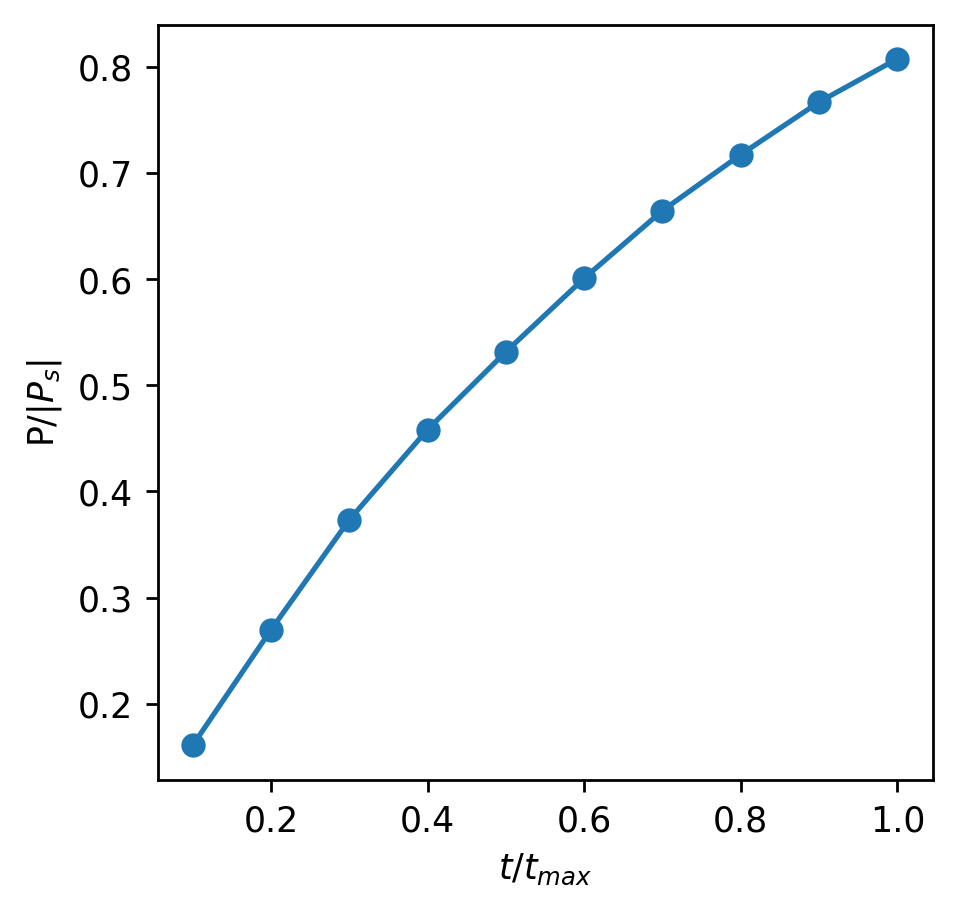

In [6]:
fig, pl = plt.subplots(figsize=(4,4), dpi=250)
f_i=0
tp=[get_p_t(data,i) for i in range(len(data))]
t=np.array([i[0] for i in tp])
pz=np.array([i[3] for i in tp])
pz=-np.mean(pz,axis=1)
pl.plot(np.array(t)/t[-1],-np.array(pz)/ps, marker=markers[f_i])
pl.set_ylabel(r'P/$\left | P_s \right |$')
pl.set_xlabel('$t/t_{max}$')

# local charge distribution

STD(\rho_{xy}) 0.06550238565093941
STD(\rho_{yz}) 0.11304093189734526


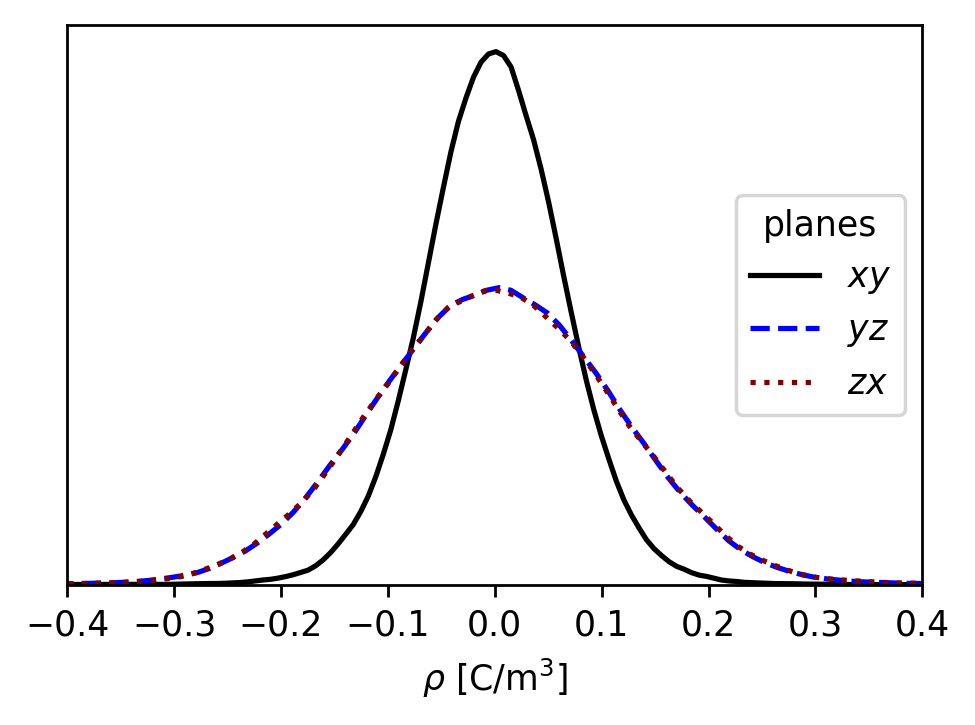

In [12]:
stdz=[]
stdy=[]
stdx=[]
pol_time=[]
P=[]

fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)

t,px,py,pz = get_p_t(data,0)

pz=pz.reshape(48,48,48)/ps*34
sns.distplot(1e-2*np.gradient(pz)[0].reshape(48*48*48), hist=False, color='black', label=r'$xy$', kde_kws={'linestyle':'solid'})
py=py.reshape(48,48,48)/ps*34
sns.distplot(1e-2*np.gradient(py)[0].reshape(48*48*48), hist=False, color='blue', label=r'$yz$', kde_kws={'linestyle':'dashed'})
px=px.reshape(48,48,48)/ps*34
sns.distplot(1e-2*np.gradient(px)[0].reshape(48*48*48), hist=False, color='maroon', label=r'$zx$', kde_kws={'linestyle':'dotted'})
pl.legend(loc='center right', title = 'planes')
pl.set_xlabel(r'$\rho$ [C/m$^3$]')
pl.set_xlim(-0.4,0.4)
plt.gca().axes.get_yaxis().set_visible(False)
print(r'STD(\rho_{xy})',np.std(1e-2*np.gradient(pz)[0].reshape(48*48*48)))
print(r'STD(\rho_{yz})',np.std(1e-2*np.gradient(py)[0].reshape(48*48*48)))

(0.06, 0.08)

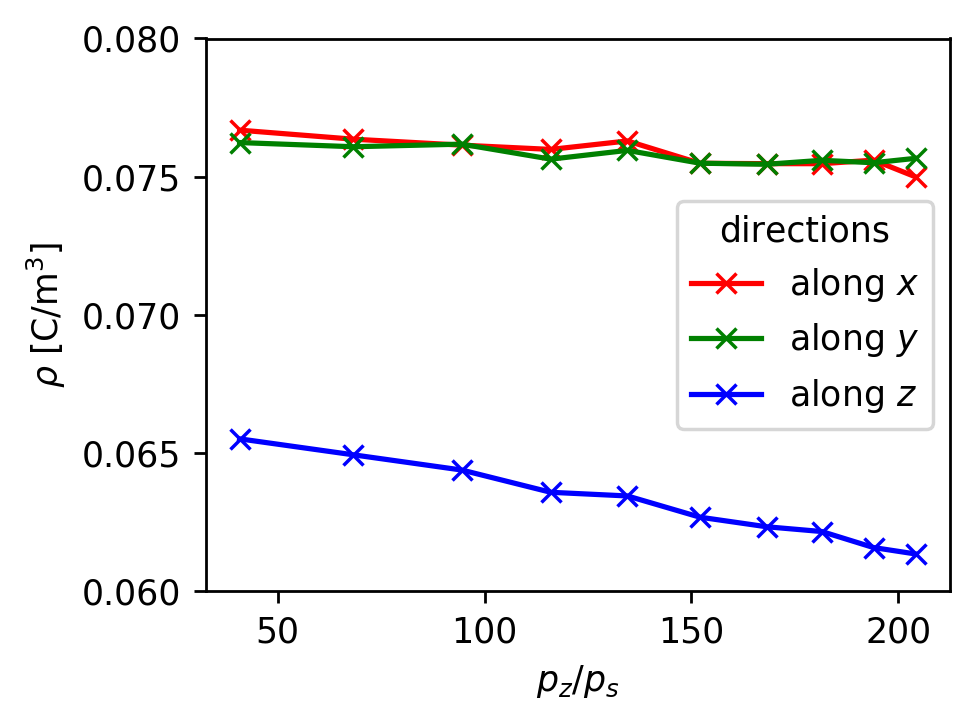

In [18]:
stdz=[]
stdy=[]
stdx=[]
pol_time=[]
P=[]

fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)

i=0
for i in range(len(data)):
    t,px,py,pz = get_p_t(data,i)
    px=px.reshape(48,48,48)/ps*34
    py=py.reshape(48,48,48)/ps*34
    pz=pz.reshape(48,48,48)/ps*34
    P.append(np.mean(pz))
    stdz.append(np.std(np.gradient(pz)[0].reshape(48*48*48)))
    stdy.append(np.std(np.gradient(py)[1].reshape(48*48*48)))
    stdx.append(np.std(np.gradient(px)[2].reshape(48*48*48)))
    pol_time.append(t*1e-3)
    i=i+1
P=np.array(P)/ps
pl.plot(P,1e-2*np.array(stdx), color='red', marker='{}'.format(markers[-3]), label=r'along $x$')
pl.plot(P,1e-2*np.array(stdy), color='green', marker='{}'.format(markers[-3]), label=r'along $y$')
pl.plot(P,1e-2*np.array(stdz), color='blue', marker='{}'.format(markers[-3]), label=r'along $z$')

pl.legend(loc='center right', title = 'directions')
pl.set_ylabel(r'$\rho$ [C/m$^3$]')
pl.set_xlabel(r'$p_z/p_s$')
pl.set_ylim(0.06,0.08)

# angles

In [19]:
Pz_xy=[]
t=[]
layer=6
for i in range(len(data)):
    t,px,py,pz = get_p_t(data,i)
    px=px.reshape(48,48,48)[:,:,layer].reshape(size*size)
    py=py.reshape(48,48,48)[:,:,layer].reshape(size*size)
    pz=pz.reshape(48,48,48)[:,:,layer].reshape(size*size)
    Pz_xy.append(list(zip(px,py,pz)))
    pol_time.append(t*1e-3)

Pz_xy=np.array(Pz_xy)

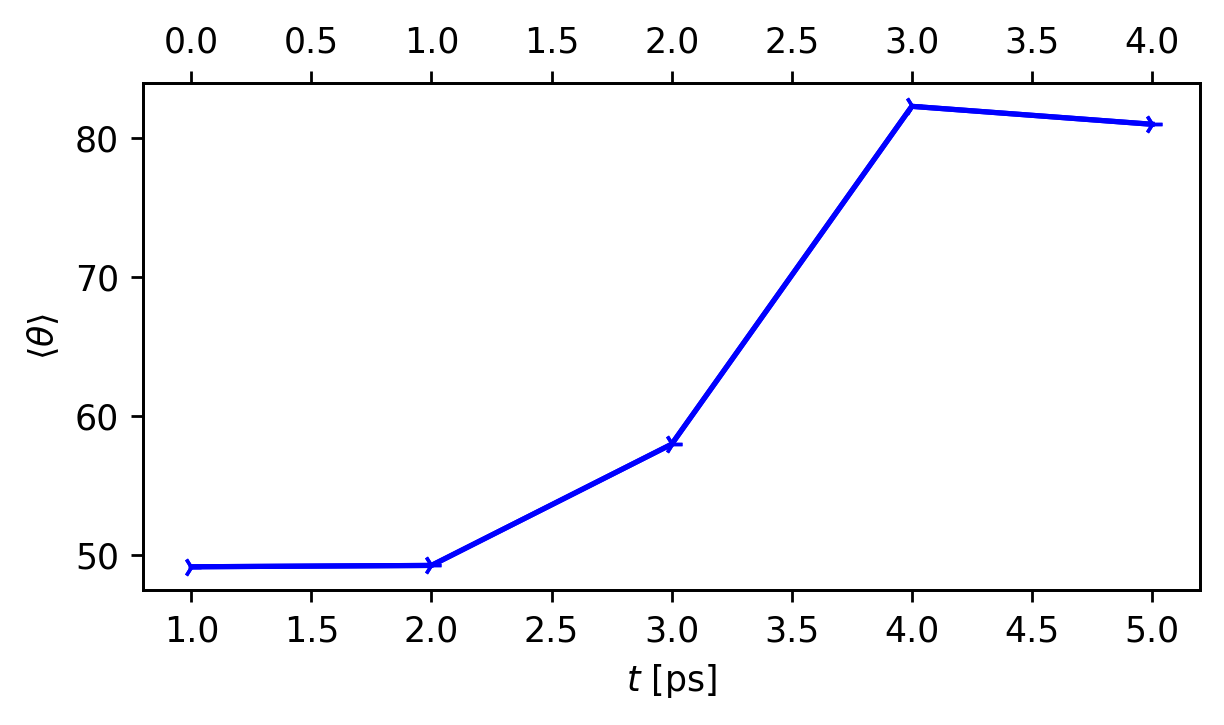

In [23]:
std=[]
mean=[]
delta=6
P=Pz_xy
for i in range(0,delta-1):
    dot_product=[]
    for j in range(len(P[i])-1):
        dot_product.append(np.arccos(np.dot(P[i][j],P[i+1][j])/np.linalg.norm(P[i][j])/np.linalg.norm(P[i+1][j])))
    angle = np.array(dot_product)*180/np.pi
    ang=dot_product
    std.append(np.std(angle))
    mean.append(np.mean(angle))
fig,pl=plt.subplots(tight_layout=True, figsize=(5,3),dpi=250)
pl.plot(pol_time[0:delta-1],mean, color='blue',marker='4')
pl.set_xlabel(r'$t$ [ps]')
pl.set_ylabel(r'$\left \langle \theta \right \rangle$', color='black')
pl2=pl.twiny()
pl2.plot(mean, color='blue',marker='4')

# polarization profile

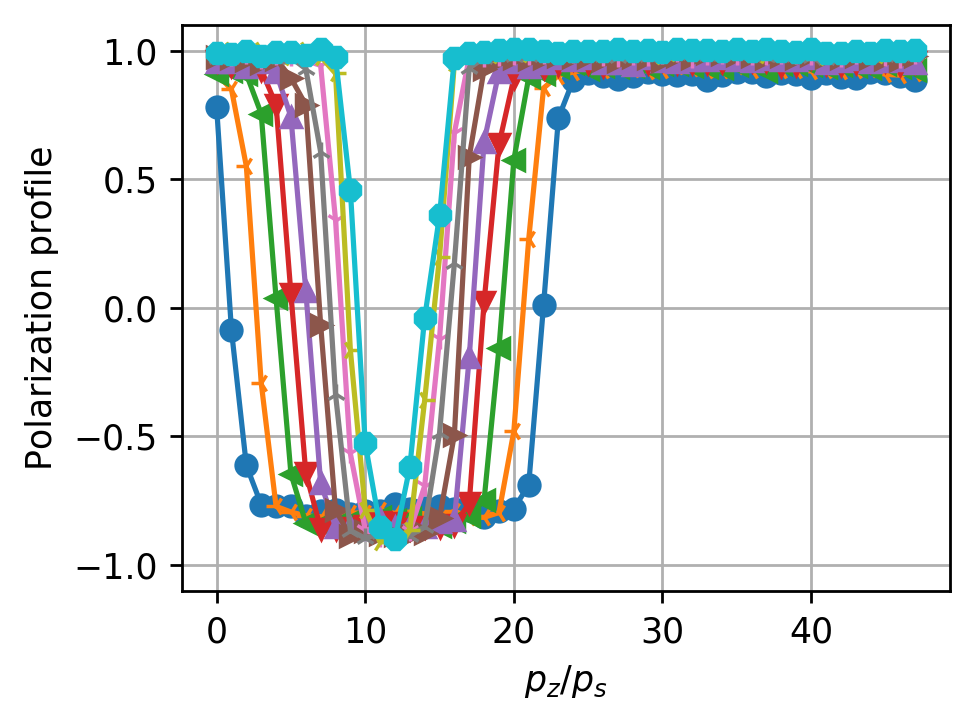

In [27]:
h_mean=[]
dw=[]
pz_mean=[]
fig,pl=plt.subplots(tight_layout=True, figsize=(4,3),dpi=250)
for j,i in enumerate([i for i in range(10)]):
    t,px,py,pz = get_p_t(data,i)
    pz=pz.reshape(48,48,48)/ps
    pz_1=np.mean(pz, axis=1)
    pz_2=np.mean(pz_1, axis=0)
    pl.plot(pz_2, marker='{}'.format(markers[j]))
pl.set_ylabel(r'Polarization profile')
pl.set_xlabel(r'$p_z/p_s$')
plt.ylim(-1.1,1.1)
plt.grid()